<a href="https://colab.research.google.com/github/wei-ting-Hsu/code-PL/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LLM Model Test

In [1]:
!pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import getpass
import os
os.environ["HUGGINGFACE_API_KEY"] = getpass.getpass()

··········


In [7]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

import pandas as pd
# read data and put it in a dataframe
# 在 google 工作表載入 gsheets
gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1AbDDxzwy2ULjE9m7Ahbb-16yTRvjSMCXNg8u6nUNTu4/edit?hl=zh-tw#gid=0')
# 從 gsheets 的工作表
sheets1 = gsheets.worksheet('hw4').get_all_values()

df = pd.DataFrame(sheets1[1:], columns=sheets1[0])

In [8]:
df.head()

,title,popular,date
0,[情報] 在湖人的最後一場比賽？LBJ:我不回答,60,4/30
1,Re: [討論] 明年再不給莫神仙打ASG 說得過去嗎?,27,4/30
2,[花邊] 火腿的未來面臨危險 不太可能回歸,99,4/30
3,[外絮] Malone: Murray在關鍵時刻 展現戰士本色,51,4/30
4,[花邊] Shams：老詹預計會再打兩年/湖人願給三年,94,4/30


In [9]:
import re
# 只保留中文字
def keep_chinese_chars(text):
    pattern = re.compile(r'[^\u4e00-\u9fff]')
    chinese_text = re.sub(pattern, '', text)
    chinese_text = chinese_text.replace("推推", "")
    return chinese_text

In [11]:
text = df['title'][0]
text = keep_chinese_chars(text)
text

'情報在湖人的最後一場比賽我不回答'

In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer

def Mistral_summarize(text):

  device = "cuda" # the device to load the model onto

  model = AutoModelForCausalLM.from_pretrained("MediaTek-Research/Breeze-7B-Instruct-v1_0")
  tokenizer = AutoTokenizer.from_pretrained("MediaTek-Research/Breeze-7B-Instruct-v1_0")

  messages = [
      {"role": "user", "content": "What is your favourite condiment?"},
      {"role": "assistant", "content": "Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!"},
      {"role": "user", "content": {text}}
  ]

  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

  model_inputs = encodeds.to(device)

  generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True)
  decoded = tokenizer.batch_decode(generated_ids)

  return decoded

In [13]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import torch

def bart_summarize(text):

    keep_chinese_chars(text)

    tokenizer = BertTokenizer.from_pretrained('hfl/chinese-bert-wwm')
    model = BertForMaskedLM.from_pretrained('hfl/chinese-bert-wwm')

    inputs = tokenizer(text, return_tensors="pt", max_length=100, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=128)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [14]:
summary = bart_summarize(text)
print(summary)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


情 報 在 湖 人 的 最 後 一 場 比 賽 我 不 回 答 ？ （ ） ？ （ ） ？ （ ） ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？ ？


In [15]:
def remove_spaces(text):
    # 使用 replace 方法來刪除空格
    return text.replace(" ", "")

output_text = remove_spaces(summary)
output_text

'情報在湖人的最後一場比賽我不回答？（）？（）？（）？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？'

In [16]:
import jieba
import jieba.analyse

jieba.analyse.extract_tags(output_text, topK=10)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.734 seconds.
DEBUG:jieba:Loading model cost 0.734 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


['情報', '湖人', '最後一場', '比賽', '回答']

In [17]:
# 使用 jieba 提取關鍵字
def extract_keywords(text):
    #text = keep_chinese_chars(text)

    summary = bart_summarize(text)
    outputt_ext = remove_spaces(summary)

    return jieba.analyse.extract_tags(outputt_ext, topK=10)  # 提取前十個關鍵字

df['keywords'] = df['title'].apply(extract_keywords)

Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a m

In [18]:
df.head()

,title,popular,date,keywords
0,[情報] 在湖人的最後一場比賽？LBJ:我不回答,60,4/30,"[情報, 湖人, 最後一場, 比賽, lbj, 回答]"
1,Re: [討論] 明年再不給莫神仙打ASG 說得過去嗎?,27,4/30,"[re, 討論, 不給, asg, 說得過, 神仙, 明年]"
2,[花邊] 火腿的未來面臨危險 不太可能回歸,99,4/30,"[花邊, 未來, 面臨, 危險, 回歸, 火腿, 不太可能]"
3,[外絮] Malone: Murray在關鍵時刻 展現戰士本色,51,4/30,"[外絮, malone, murray, 關鍵, 時刻, 展現, 戰士, 本色]"
4,[花邊] Shams：老詹預計會再打兩年/湖人願給三年,94,4/30,"[nba, 花邊, shams, 預計會, 兩年, 湖人, 願給, 三年]"


In [19]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from community import community_louvain

In [20]:
G = nx.Graph()

for index, row in df.iterrows():
    author = row['title']
    keywords = row['keywords']

    G.add_node(author, type='author')

    for keyword in keywords:
        G.add_node(keyword, type='keyword')
        G.add_edge(author, keyword)

In [21]:
keywords

['g2', '情報', 'shams', '丟掉', '20', '分優勢', '稻草', '一根', '第二']

In [22]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
from matplotlib.font_manager import fontManager
# 改style要在改font之前
# plt.style.use('seaborn')
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-04-30 10:30:00--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.253.117.101, 172.253.117.138, 172.253.117.102, ...
Connecting to drive.google.com (drive.google.com)|172.253.117.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-04-30 10:30:00--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.135.132, 2607:f8b0:400e:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.135.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M   120MB/s    in 0.2s    

2024-04-30 10

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


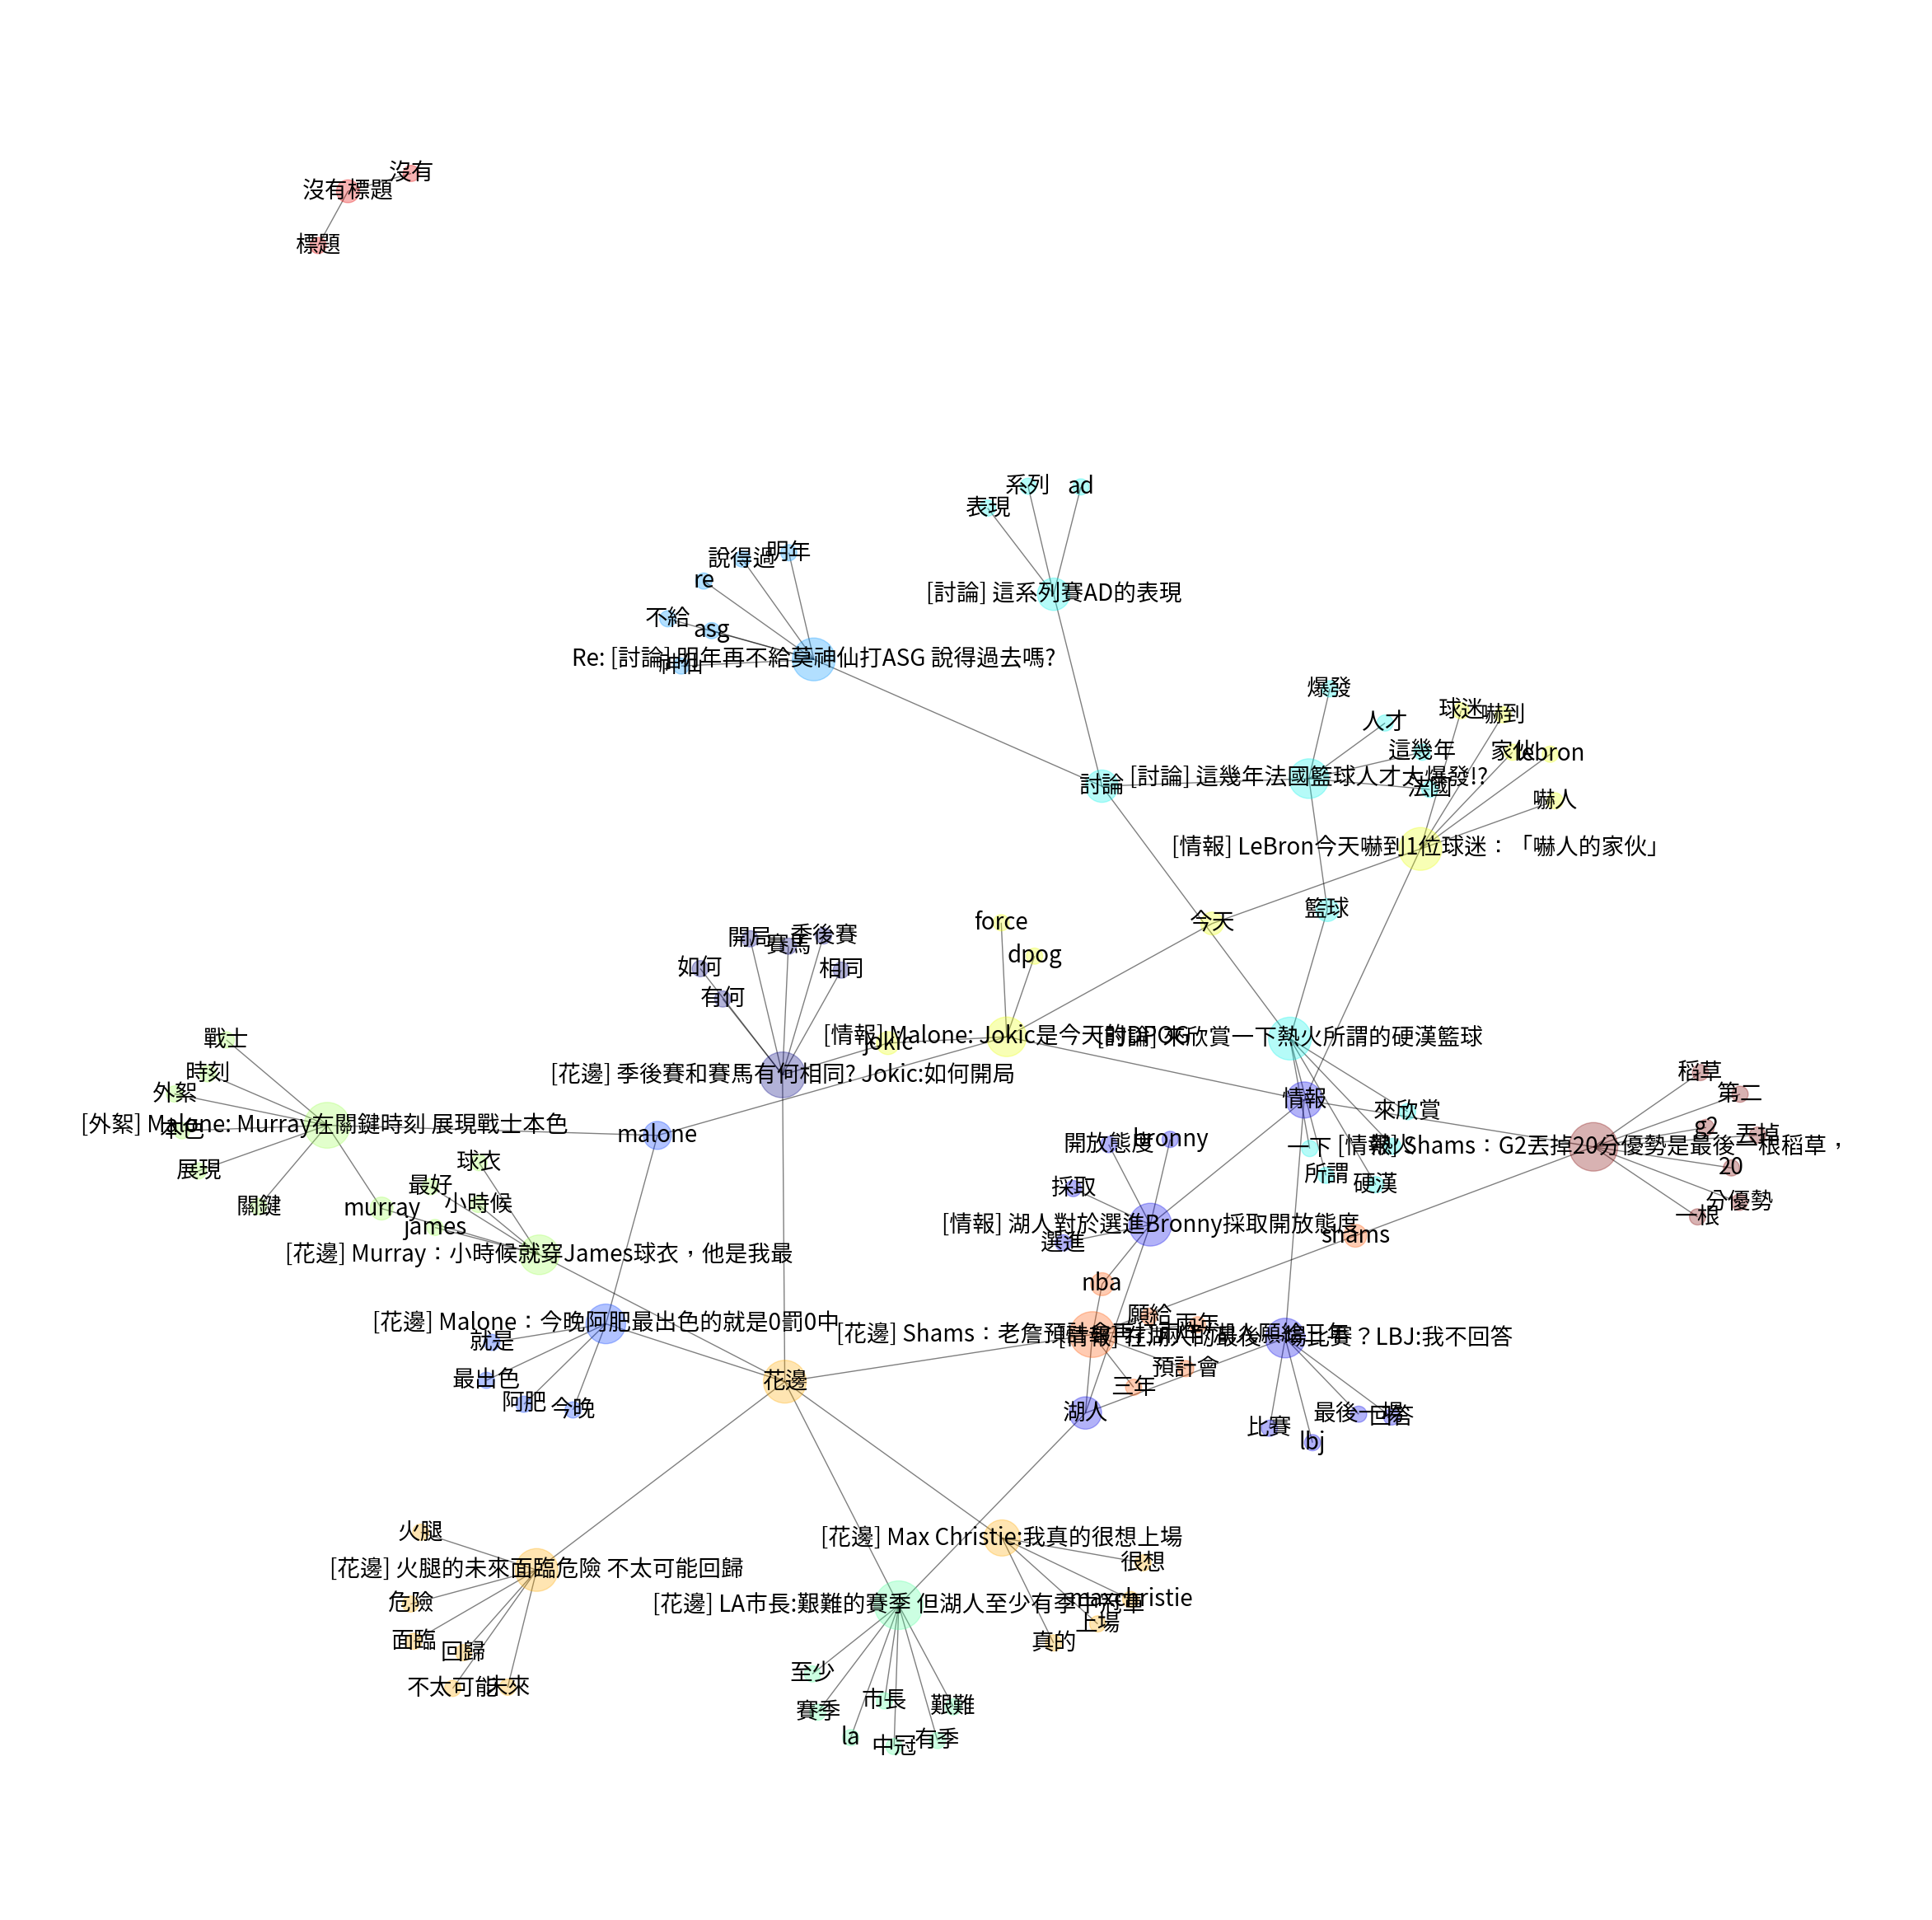

In [23]:
partition = community_louvain.best_partition(G)

community_colors = [partition[node] for node in G.nodes()]

cmap = plt.cm.jet
colors_with_alpha = [cmap(community_color / max(community_colors)) for community_color in community_colors]

colors_with_alpha = [(r, g, b, 0.3) for r, g, b, _ in colors_with_alpha]

node_sizes = [200 * G.degree(node) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.2, iterations=80)

plt.figure(figsize=(30, 30))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color=colors_with_alpha, node_size=node_sizes, cmap=plt.cm.jet)
nx.draw_networkx_labels(G, pos, font_size=20, font_family='Taipei Sans TC Beta')

plt.axis('off')
plt.show()